<a href="https://colab.research.google.com/github/JessBinder/goatools/blob/main/CCLE_genescore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From DepMap Public 22Q4
ScreenNaiveGeneScore.csv 
Post-Chronos LFC collapsed by mean of sequences and median of guides, computed per library-screen type then concatenated. - Columns: Gene - Rows: ScreenID

This DepMap release contains data from CRISPR knockout screens from project Achilles, as well as genomic characterization data from the CCLE project.

###############

[DepMap README.txt](https://depmap.org/portal/download/all/#:~:text=by%20file%20name...-,README,-.txt)
###############



In [1]:
!pip install Bio
!pip install unipressed 
!pip install goatools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 272 kB 34.8 MB/s 
     |████████████████████████████████| 3.1 MB 48.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.8 MB 32.0 MB/s 
     |████████████████████████████████| 149 kB 64.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=19d57b74fb0a47c813cedeb091c3c3729d9ab0a952e573206eda41a153c9fb2a
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6

In [2]:
import os
import re
import glob
import gzip
import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# extract models that are performed on suspended cells
models_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/Model.csv")
models_df.head()


,ModelID,PatientID,CellLineName,StrippedCellLineName,Age,SourceType,SangerModelID,RRID,DepmapModelType,GrowthPattern,...,SourceDetail,CatalogNumber,CCLEName,COSMICID,PublicComments,WTSIMasterCellID,OncotreeCode,OncotreeSubtype,OncotreePrimaryDisease,OncotreeLineage
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,60.0,Commercial,SIDM00105,CVCL_0465,HGSOC,Adherent,...,ATCC,NaN,NIHOVCAR3_OVARY,905933.0,NaN,2201.0,HGSOC,High-Grade Serous Ovarian Cancer,Ovarian Epithelial Tumor,Ovary/Fallopian Tube
1,ACH-000002,PT-5qa3uk,HL-60,HL60,36.0,Commercial,SIDM00829,CVCL_0002,AML,Suspension,...,ATCC,NaN,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,905938.0,NaN,55.0,AML,Acute Myeloid Leukemia,Acute Myeloid Leukemia,Myeloid
2,ACH-000003,PT-puKIyc,CACO2,CACO2,72.0,Commercial,SIDM00891,CVCL_0025,COAD,Adherent,...,ATCC,NaN,CACO2_LARGE_INTESTINE,NaN,NaN,NaN,COAD,Colon Adenocarcinoma,Colorectal Adenocarcinoma,Bowel
3,ACH-000004,PT-q4K2cp,HEL,HEL,30.0,Commercial,SIDM00594,CVCL_0001,AML,Suspension,...,DSMZ,NaN,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,907053.0,NaN,783.0,AML,Acute Myeloid Leukemia,Acute Myeloid Leukemia,Myeloid
4,ACH-000005,PT-q4K2cp,HEL 92.1.7,HEL9217,30.0,Commercial,SIDM00593,CVCL_2481,AML,Unknown,...,ATCC,NaN,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,NaN,AML,Acute Myeloid Leukemia,Acute Myeloid Leukemia,Myeloid


In [5]:
models_df[["ModelID", "GrowthPattern"]].shape

(1826, 2)

In [6]:
sus_models = []
for suspension in models_df:
  sus = models_df[models_df["GrowthPattern"] == 'Suspension']


susmodels_df = pd.DataFrame(sus, columns=['ModelID', 'GrowthPattern'])
susmodels_df.head()

,ModelID,GrowthPattern
1,ACH-000002,Suspension
3,ACH-000004,Suspension
5,ACH-000006,Suspension
22,ACH-000024,Suspension
32,ACH-000034,Suspension


In [7]:
susmodels_df.shape

(126, 2)

In [8]:
#Convert modelID to screenID
screenIDs = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/CRISPRScreenMap.csv")
mergeIDs = pd.merge(susmodels_df, screenIDs, on='ModelID')
mergeIDs.head()

,ModelID,GrowthPattern,ScreenID
0,ACH-000004,Suspension,SC-000004.AV01
1,ACH-000024,Suspension,SC-000024.AV01
2,ACH-000024,Suspension,SC-000024.KY01
3,ACH-000045,Suspension,SC-000045.AV02
4,ACH-000070,Suspension,SC-000070.AV01


In [9]:
gene_scores = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/ScreenNaiveGeneScore.csv")
gene_scores.shape

(1270, 18041)

###What do the gene scores represent?
Compute the naive gene score by collapsing the passing LFC data to a screen x gene matrix.
ScreenNaiveGeneScore.csv descripton: 
* Post-Chronos LFC collapsed by mean of sequences and median of guides, computed per library-screen type then concatenated. - Columns: Gene - Rows: ScreenID



---
* unintegrated (screen-level)  
* naive (just averaging guides and replicates)
* gene score is usally a measurement of quality, dependency, or interest



In [10]:
#select genescores from suspension models only
suspended_genescores = pd.merge(gene_scores, mergeIDs, on='ScreenID')

suspended_genescores.shape

(66, 18043)

###How many genes and samples (e.g. screens) did you find?


*   66 samples
*   18040 genes



In [11]:
df = suspended_genescores.drop(['ModelID', "GrowthPattern"], axis=1)
df = df.transpose()
df.columns = df.iloc[0]
df = df.drop(['ScreenID'], axis=0)
df.head()

ScreenID,SC-000004.AV01,SC-000024.AV01,SC-000045.AV02,SC-000070.AV01,SC-000113.AV01,SC-000146.AV01,SC-000168.AV01,SC-000183.AV01,SC-000206.AV01,SC-000257.AV01,...,SC-000183.KY01,SC-000269.KY01,SC-000271.KY01,SC-000336.KY01,SC-000438.KY01,SC-000656.KY01,SC-000660.KY01,SC-000817.KY01,SC-000864.KY01,SC-000945.KY01
A1BG (1),0.151671,-0.047451,-0.032632,0.192899,-0.041046,0.035408,0.085042,0.438621,-0.087706,-0.493885,...,0.294637,-0.401228,-0.585524,-0.30704,-0.617885,-0.447767,-0.53071,0.214192,-0.412976,-0.085331
A1CF (29974),-0.044279,0.329193,0.394009,-0.022132,-0.041696,0.069447,0.039114,0.460416,0.021211,-0.575721,...,-2.997963,0.114107,-0.012289,0.014979,-0.232908,0.235893,-0.2248,-0.52359,-0.081497,-0.070151
A2M (2),-0.417262,-0.156935,0.012305,-0.011894,0.006366,-0.124061,0.183349,-0.330162,0.050771,-0.071569,...,-0.361668,0.455661,0.095173,0.09662,0.451762,-0.117168,-0.013466,0.623452,0.228598,0.061812
A2ML1 (144568),-0.076463,0.038502,0.174843,0.143126,0.171757,0.234643,0.280153,-0.116494,0.037769,0.137426,...,0.214946,-0.007214,-0.128055,-0.031683,0.364243,-0.081897,-1.592738,-0.633496,0.131247,-0.428659
A3GALT2 (127550),0.238897,0.210706,0.262831,-0.096641,0.238815,0.202251,-0.164795,-0.142644,-0.149247,-0.922065,...,0.4592,-0.391737,-0.384549,-0.120552,-0.348193,-0.679652,-0.404331,-0.395049,-0.000904,-0.370711


In [12]:
#list top 50 genes with the most variance
df['mean'] = df.mean(axis=1)
df['var'] = df.var(axis=1)
df = df.sort_values(by=['var'], ascending=False)
df.head(50)

ScreenID,SC-000004.AV01,SC-000024.AV01,SC-000045.AV02,SC-000070.AV01,SC-000113.AV01,SC-000146.AV01,SC-000168.AV01,SC-000183.AV01,SC-000206.AV01,SC-000257.AV01,...,SC-000271.KY01,SC-000336.KY01,SC-000438.KY01,SC-000656.KY01,SC-000660.KY01,SC-000817.KY01,SC-000864.KY01,SC-000945.KY01,mean,var
PGAM4 (441531),0.08603,0.460864,0.262951,0.149926,0.344051,0.215589,0.042484,0.206836,0.11963,0.816107,...,-3.788552,-2.320761,-3.847911,-8.697962,-8.888337,-5.672666,-1.684568,-1.715809,-0.661455,4.490267
H2AC15 (8330),0.123829,0.079593,0.029921,-0.13057,-0.329324,0.12516,-0.276513,-0.718014,-0.401845,0.557197,...,-3.660792,-2.862146,-3.722329,-7.243092,-7.913041,-5.787735,-3.321977,-2.48216,-0.979456,4.029453
H2BC3 (3018),-0.525814,-0.171368,-0.439208,-0.068819,-0.463769,-0.247483,-0.456744,-0.619838,-0.714921,-0.1981,...,-3.737234,-1.980495,-5.957601,-7.059629,-4.841557,-6.41115,-2.250067,-2.767648,-1.142134,3.715399
EEF1A1 (1915),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.806639,-2.404132,-2.139253,-7.04914,-6.039805,-3.563885,-0.472167,-1.046082,-3.197969,3.674232
RAN (5901),-2.8011,-6.493403,-1.760536,-0.716145,-2.176999,-4.437178,-1.507307,-5.959154,-2.287617,-4.846152,...,-3.828844,-2.294155,-5.771493,-7.408456,-7.118905,-6.098221,-3.24558,-3.808067,-3.596997,3.670690
IRF4 (3662),-0.120971,-4.759111,-0.135197,-0.175317,0.013032,-0.085336,-0.204984,-6.027436,-2.344885,-1.230219,...,0.120929,0.005707,0.083051,-6.546001,-0.270976,-5.176036,0.277349,0.12057,-1.188741,3.280821
H2BC4 (8347),-0.777,-0.937297,-1.008725,-0.297474,-1.052162,-0.221381,-1.036163,-1.653132,-0.893008,-0.070315,...,-2.632652,-1.942368,-5.049471,-6.549645,-7.918157,-5.695006,-4.352098,-2.922145,-1.441886,2.970243
SNRPD3 (6634),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.8983,-2.19287,-3.187367,-7.927496,-4.186775,-5.211215,-3.824559,-2.552073,-4.080115,2.966973
RPL13A (23521),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.240842,-1.783983,-1.724495,-6.893514,-5.928869,-3.612958,-1.432548,-1.163032,-2.917394,2.881719
HSPE1 (3336),-2.628559,-8.054383,-2.080605,-1.013459,-2.493902,-3.325417,-1.75597,-5.607792,-2.251554,-5.631917,...,-3.272062,-3.098611,-2.548254,-7.051788,-7.200763,-4.287688,-2.659332,-1.344692,-3.168769,2.823518


##Produce a heat map of the top 50 genes with the most variance.
_________

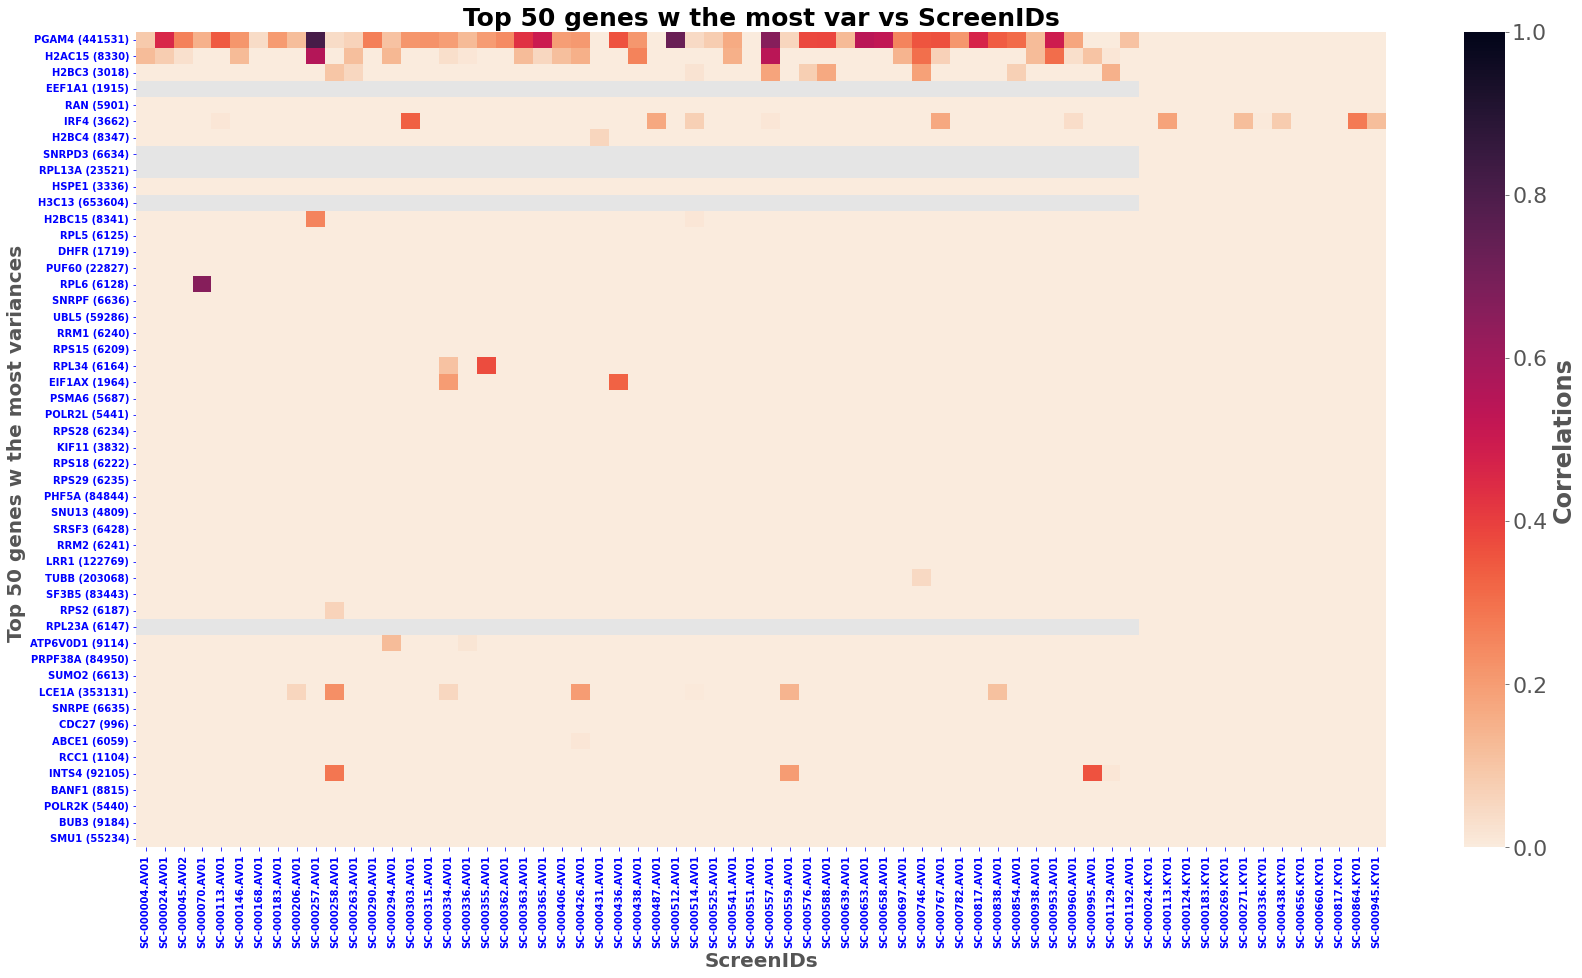

In [13]:
result = df.head(50)
result = result.astype(float)
result = result.drop(['mean', "var"], axis=1)
plt.style.use("ggplot")
plt.figure(figsize=(28,15))
b = sns.heatmap(result, vmin=0, vmax=1,cmap='rocket_r', fmt="g", cbar_kws={'label': 'Correlations'},
               annot_kws={"size":12})
 
plt.title("Top 50 genes w the most var vs ScreenIDs", fontsize =25, weight = "bold")
plt.xlabel('ScreenIDs', fontsize =20, weight = "bold")
plt.ylabel('Top 50 genes w the most variances ', fontsize =20, weight = "bold")
_, ylabels = plt.yticks()
b.set_yticklabels(ylabels, size=10, weight="bold")
_, xlabels = plt.xticks()
b.set_xticklabels(xlabels, size=10, weight="bold", rotation = 90)

b.figure.axes[-1].yaxis.label.set_size(24)
b.figure.axes[-1].yaxis.label.set_fontweight(1000)
cax = b.figure.axes[-1]
cax.tick_params(labelsize=22)

b.tick_params(direction='out', colors='b')

plt.savefig('top50var.png')
plt.show()

In [14]:
top50 = df.head(50)
top50 = top50.astype("string")
top50 = top50.reset_index(level=0)
top50 = top50.rename(columns = {'index':'geneID'})
top50 = pd.DataFrame(top50, columns=['geneID'])
top50[['Genename','NCBI_id']] = top50.geneID.str.split(expand=True)
top50['NCBI_id'] = top50['NCBI_id'].str.replace(r"(","")
top50['NCBI_id'] = top50['NCBI_id'].str.replace(r")","")
top50 = top50.drop(['geneID'], axis=1)
top50['NCBI_id']=top50['NCBI_id'].astype(int)
top50.to_csv('/content/drive/MyDrive/Colab Notebooks/data/top50_genes.csv', index=False)
top50

<ipython-input-14-f8e2f72e0e16>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top50['NCBI_id'] = top50['NCBI_id'].str.replace(r"(","")
<ipython-input-14-f8e2f72e0e16>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top50['NCBI_id'] = top50['NCBI_id'].str.replace(r")","")


,Genename,NCBI_id
0,PGAM4,441531
1,H2AC15,8330
2,H2BC3,3018
3,EEF1A1,1915
4,RAN,5901
5,IRF4,3662
6,H2BC4,8347
7,SNRPD3,6634
8,RPL13A,23521
9,HSPE1,3336


##From these top 50 genes, Map each gene to their GO Biological Process
* For each pathway, calculate the number of genes (of your top 50 genes) that are
included.
* Create a bar graph denoting the # genes for each pathway (sorted from large to small —> if there are too many bars, only show the top 20 most abundant pathways

Download GO Associations

In [16]:
from goatools.base import download_ncbi_associations
fin_gene2go = download_ncbi_associations()


$ get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
FTP RETR ftp.ncbi.nlm.nih.gov gene/DATA gene2go.gz -> gene2go.gz
$ gunzip gene2go.gz


In [17]:
from goatools.anno.genetogo_reader import Gene2GoReader
objanno_hsa = Gene2GoReader(fin_gene2go, taxids=[9606])

HMS:0:00:05.590857 339,664 annotations, 20,697 genes, 19,000 GOs, 1 taxids READ: gene2go 


In [18]:
ns2assc_hsa1 = objanno_hsa.get_ns2assc()
goa = pd.DataFrame.from_dict(ns2assc_hsa1)
#goa = goa.astype("string")
goa = goa.reset_index(level=0)
goa = goa.rename(columns = {'index':'NCBI_id'})
goa

,NCBI_id,MF,CC,BP
0,2,"{GO:0005515, GO:0042802, GO:0004867, GO:004840...","{GO:0062023, GO:0070062, GO:0005576, GO:000561...","{GO:0001553, GO:0007584, GO:0051384, GO:199040..."
1,9,{GO:0004060},{GO:0005829},{GO:0006805}
2,10,"{GO:0005515, GO:0004060}",{GO:0005829},{GO:0006805}
3,12,"{GO:0005515, GO:0003677, GO:0004867}","{GO:0062023, GO:0005634, GO:0034774, GO:003557...","{GO:0006954, GO:0010951, GO:0006953, GO:001921..."
4,13,"{GO:0016298, GO:0005515, GO:0019213, GO:001717...",{GO:0005789},"{GO:0006629, GO:0006805, GO:0010898}"
...,...,...,...,...
20652,106614088,NaN,NaN,{GO:0035195}
20653,107985879,NaN,NaN,{GO:0010468}
20654,109136579,NaN,NaN,{GO:2000147}
20655,120766137,NaN,NaN,{GO:0006417}


In [19]:
goa_bp = pd.DataFrame(goa, columns=['NCBI_id','BP'])
goa_bp['NCBI_id']=goa['NCBI_id'].astype(int)
goa_bp.to_csv('/content/drive/MyDrive/Colab Notebooks/data/goa_bp.csv', index=False)
goa_bp

,NCBI_id,BP
0,2,"{GO:0001553, GO:0007584, GO:0051384, GO:199040..."
1,9,{GO:0006805}
2,10,{GO:0006805}
3,12,"{GO:0006954, GO:0010951, GO:0006953, GO:001921..."
4,13,"{GO:0006629, GO:0006805, GO:0010898}"
...,...,...
20652,106614088,{GO:0035195}
20653,107985879,{GO:0010468}
20654,109136579,{GO:2000147}
20655,120766137,{GO:0006417}


In [20]:
top50_goa = pd.merge(top50, goa_bp, on='NCBI_id')
top50_goa = top50_goa.drop(['NCBI_id'], axis=1)
top50_goa = top50_goa.astype("string")
top50_goa['BP'] = top50_goa['BP'].str.replace(r"{","")
top50_goa['BP'] = top50_goa['BP'].str.replace(r"}","")
top50_goa['BP'] = top50_goa['BP'].str.replace(r"'","")
top50_goa['BP'] = top50_goa['BP'].str.replace(r", ",";")
newdf = top50_goa.BP.str.split(";",expand=True)
top50bp = pd.concat([top50_goa, newdf], axis=1)
top50bp = top50bp.drop(['BP'], axis=1)
top50bp

<ipython-input-20-3b8d1639ef68>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top50_goa['BP'] = top50_goa['BP'].str.replace(r"{","")
<ipython-input-20-3b8d1639ef68>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top50_goa['BP'] = top50_goa['BP'].str.replace(r"}","")


,Genename,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,PGAM4,GO:0006096,GO:1902093,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,H2AC15,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,H2BC3,GO:0006334,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,EEF1A1,GO:0071364,GO:1904714,GO:0006412,GO:1900022,GO:0006414,GO:0044829,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,RAN,GO:0035281,GO:0016032,GO:0000070,GO:1902570,GO:0000278,GO:0007286,GO:0042307,GO:0061015,GO:0071389,...,GO:0051301,GO:0000054,GO:0000056,GO:0030036,GO:0006259,GO:0046039,GO:0032092,GO:0006611,GO:0007052,GO:0000055
5,IRF4,GO:0042832,GO:0032736,GO:0043011,GO:0006357,GO:0043966,GO:0043967,GO:0045622,GO:0032743,GO:0002376,...,GO:0120162,GO:0034122,GO:0032733,GO:0045944,GO:0043388,GO:0042110,GO:0072540,<NA>,<NA>,<NA>
6,H2BC4,GO:0061844,GO:0019731,GO:0006334,GO:0050830,GO:0002227,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,SNRPD3,GO:0000387,GO:0008380,GO:0036261,GO:1903241,GO:0006479,GO:0000398,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
8,RPL13A,GO:0060425,GO:0002181,GO:0048246,GO:1901194,GO:0032496,GO:0006412,GO:0071346,GO:0017148,GO:0042592,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
9,HSPE1,GO:0051085,GO:0001649,GO:0006986,GO:0006919,GO:0006457,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [21]:
top50_goa = pd.merge(top50, goa_bp, on='NCBI_id')
top50_goa = top50_goa.drop(['NCBI_id'], axis=1)
top50_goa = top50_goa.astype("string")
top50_goa['BP'] = top50_goa['BP'].str.replace(r"{","")
top50_goa['BP'] = top50_goa['BP'].str.replace(r"}","")
top50_goa['BP'] = top50_goa['BP'].str.replace(r"'","")
top50_goa['BP'] = top50_goa['BP'].str.replace(r", ",";")
top50_goa["Biological_process"] = top50_goa.BP.str.split(";")
top50_goa = top50_goa.drop(columns='BP').explode("Biological_process")
top50_goa = top50_goa.astype("string")
top50_goa.to_csv('top50_bp.csv', index=False)
top50_goa
#top50bp = pd.concat([top50_goa, bpstring], axis=1)


<ipython-input-21-4c6ad7d21666>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top50_goa['BP'] = top50_goa['BP'].str.replace(r"{","")
<ipython-input-21-4c6ad7d21666>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  top50_goa['BP'] = top50_goa['BP'].str.replace(r"}","")


,Genename,Biological_process
0,PGAM4,GO:0006096
0,PGAM4,GO:1902093
1,H2AC15,<NA>
2,H2BC3,GO:0006334
3,EEF1A1,GO:0071364
...,...,...
48,BUB3,GO:0007094
48,BUB3,GO:0051321
49,SMU1,GO:0008380
49,SMU1,GO:0000381


In [22]:
top50_goa["Biological_process"].nunique()

193

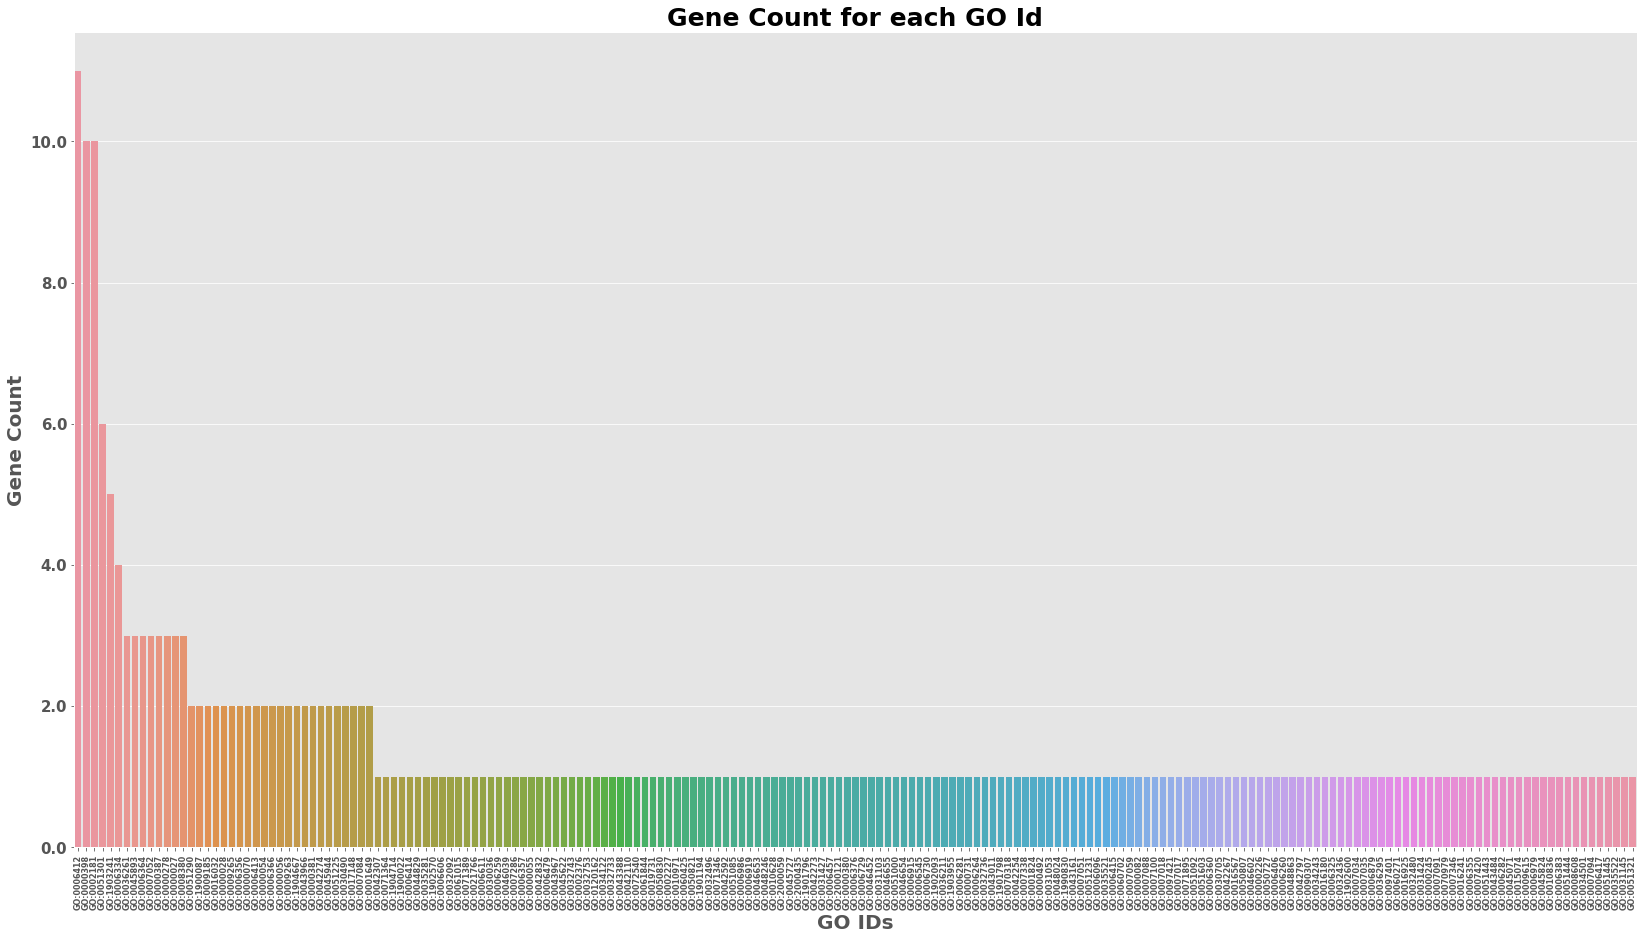

In [27]:
plt.style.use("ggplot")
plt.figure(figsize=(28,15))
b = sns.countplot(x='Biological_process',data=top50_goa, order=top50_goa['Biological_process'].value_counts().index)
plt.title("Gene Count for each GO Id", fontsize =25, weight = "bold")
plt.xlabel('GO IDs', fontsize =20, weight = "bold")
plt.ylabel('Gene Count', fontsize =20, weight = "bold")
_, ylabels = plt.yticks()
b.set_yticklabels(b.get_yticks(), size = 15, weight = "bold")
_, xlabels = plt.xticks()
b.set_xticklabels(xlabels, size=8, weight="bold", rotation = 90)
#b.tick_params(direction='out', colors='b')

plt.savefig('barplot.png')
plt.show()

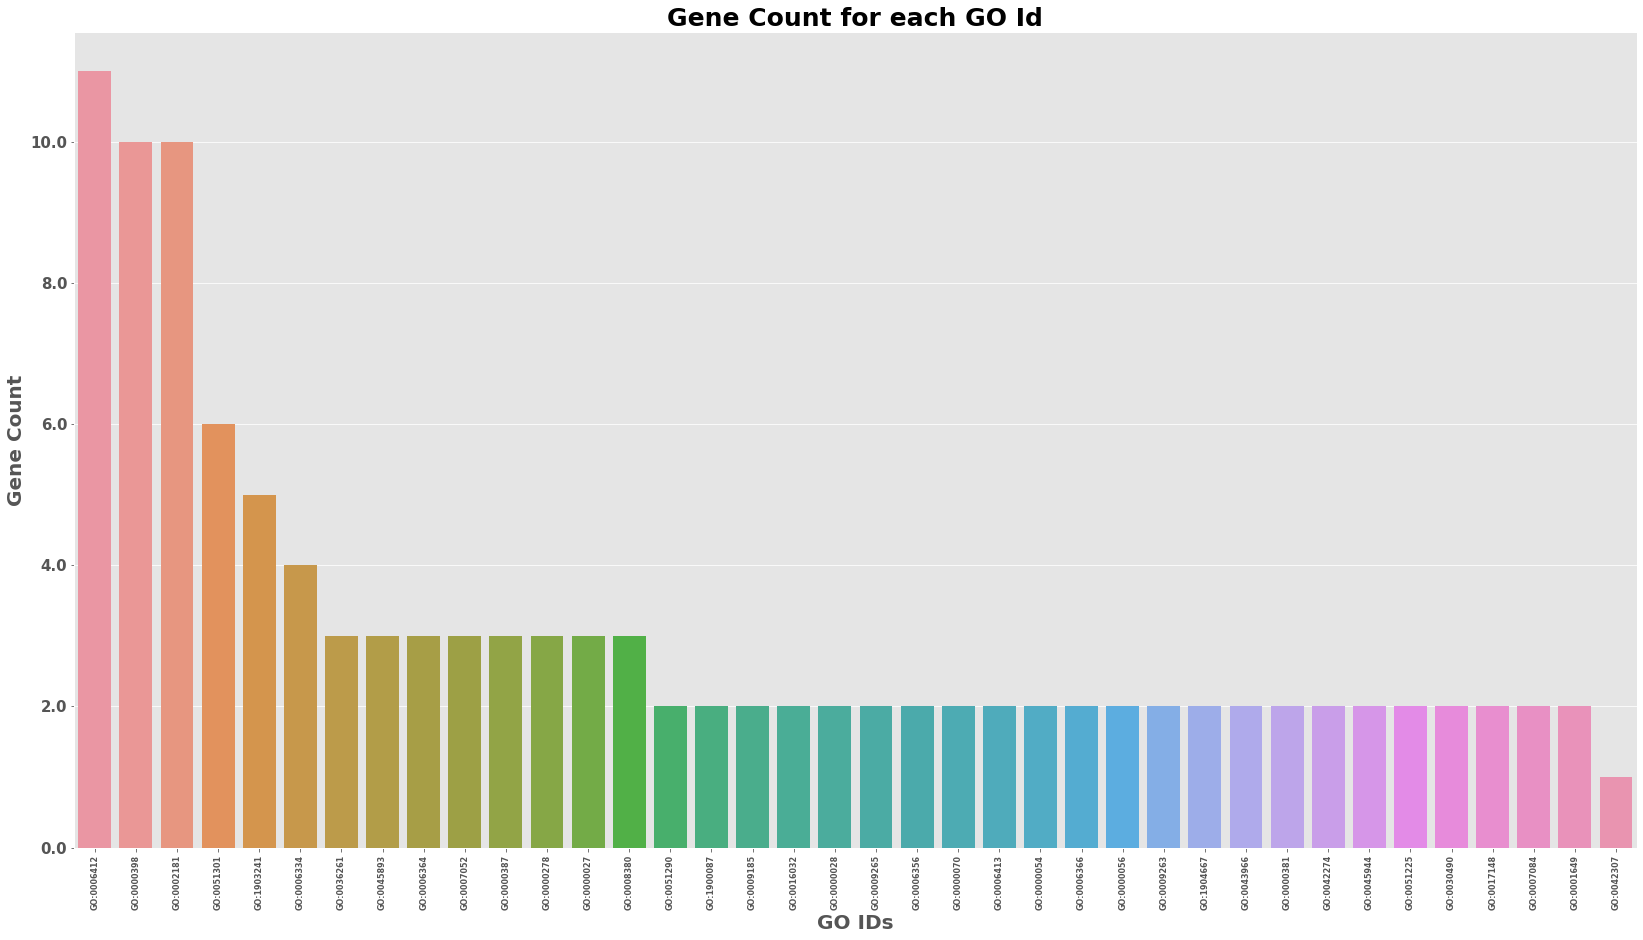

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(28,15))
b = sns.countplot(x='Biological_process',data=top50_goa, order=top50_goa['Biological_process'].value_counts().iloc[:38].index)
plt.title("Gene Count for each GO Id", fontsize =25, weight = "bold")
plt.xlabel('GO IDs', fontsize =20, weight = "bold")
plt.ylabel('Gene Count', fontsize =20, weight = "bold")
_, ylabels = plt.yticks()
b.set_yticklabels(b.get_yticks(), size = 15, weight = "bold")
_, xlabels = plt.xticks()
b.set_xticklabels(xlabels, size=8, weight="bold", rotation = 90)
#b.tick_params(direction='out', colors='b')

plt.savefig('barplot.png')
plt.show()

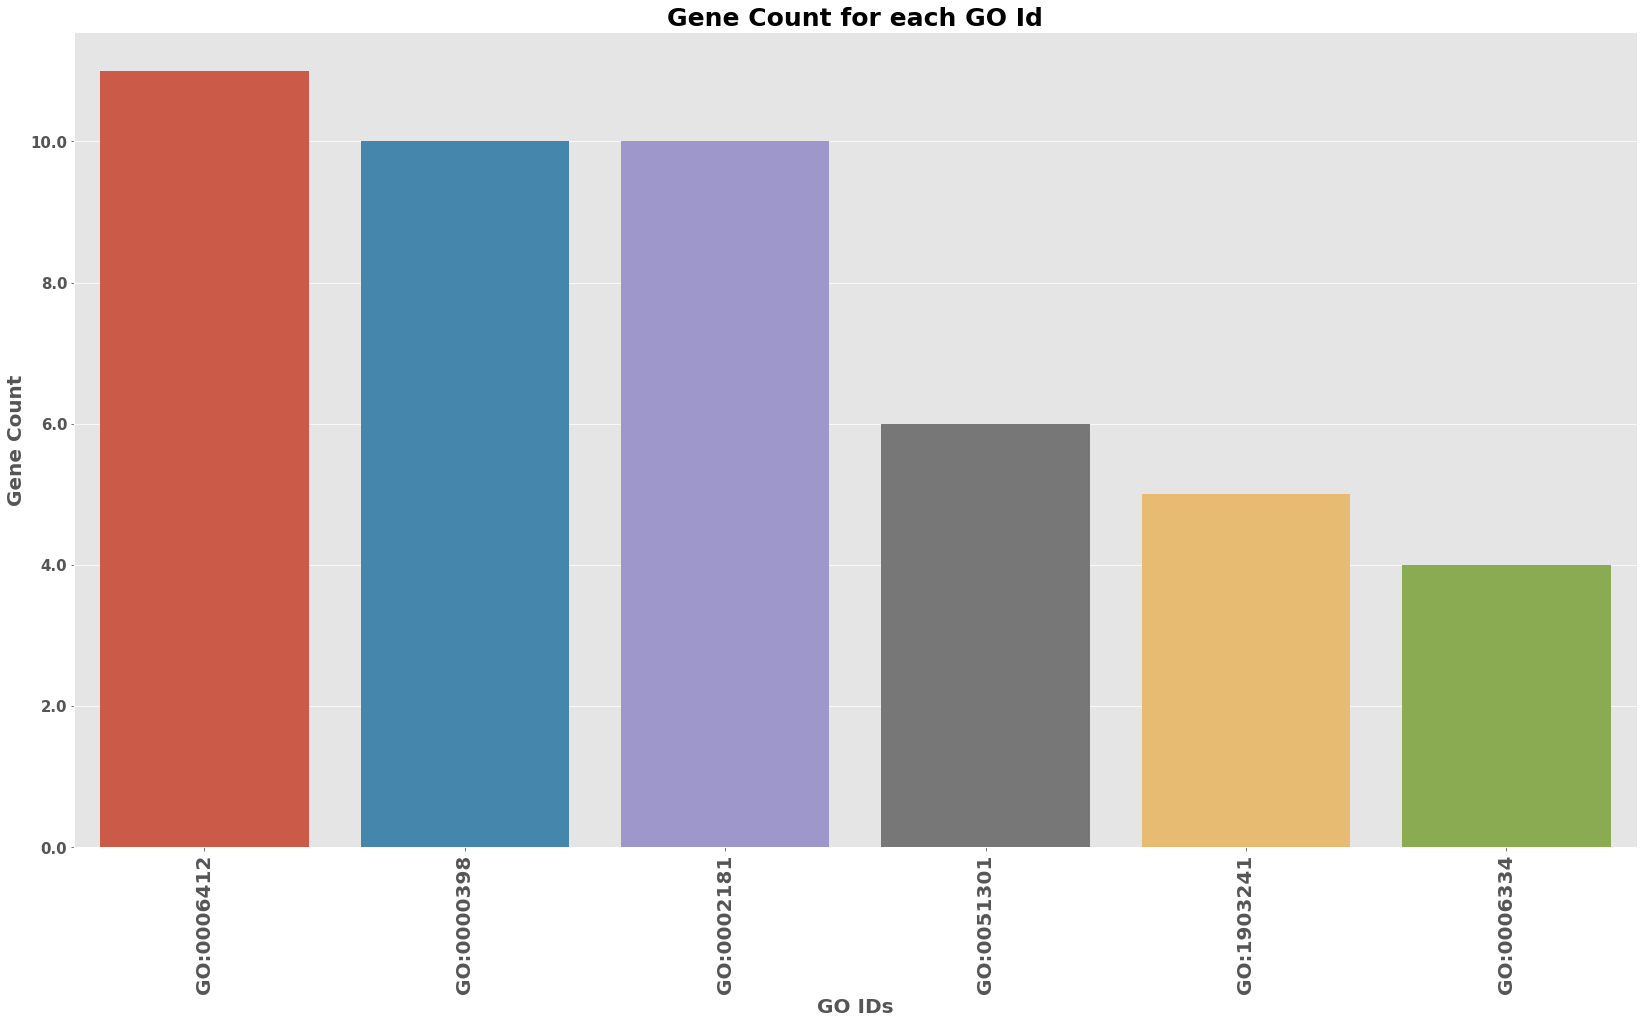

In [31]:
plt.style.use("ggplot")
plt.figure(figsize=(28,15))
b = sns.countplot(x='Biological_process',data=top50_goa, order=top50_goa['Biological_process'].value_counts().iloc[:6].index)
plt.title("Gene Count for each GO Id", fontsize =25, weight = "bold")
plt.xlabel('GO IDs', fontsize =20, weight = "bold")
plt.ylabel('Gene Count', fontsize =20, weight = "bold")
_, ylabels = plt.yticks()
b.set_yticklabels(b.get_yticks(), size = 15, weight = "bold")
_, xlabels = plt.xticks()
b.set_xticklabels(xlabels, size=20, weight="bold", rotation = 90)
#b.tick_params(direction='out', colors='b')

plt.savefig('barplot.png')
plt.show()

###Cross Validataion using NCBI mapper

[code credit](https://github.com/mousepixels/sanbomics_scripts/blob/main/GO_in_python.ipynb)

###Create background gene list from NCBI

###1) Download mouse (TaxID=9606) protein-coding genes
Query NCBI Gene:
* "9606"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]
* Click "Send to:"
* Select "File"
* Select "Create File" button 
 (Note :The default name of the tsv file is gene_result.txt)

In [32]:
list_of_genes = top50['NCBI_id'].to_list()
print('List of NCBI_id: ', list_of_genes)

List of NCBI_id:  [441531, 8330, 3018, 1915, 5901, 3662, 8347, 6634, 23521, 3336, 653604, 8341, 6125, 1719, 22827, 6128, 6636, 59286, 6240, 6209, 6164, 1964, 5687, 5441, 6234, 3832, 6222, 6235, 84844, 4809, 6428, 6241, 122769, 203068, 83443, 6187, 6147, 9114, 84950, 6613, 353131, 6635, 996, 6059, 1104, 92105, 8815, 5440, 9184, 55234]


###Download GO Associations

In [33]:
from goatools.cli.ncbi_gene_results_to_python import ncbi_tsv_to_py

ncbi_tsv = '/content/drive/MyDrive/Colab Notebooks/data/gene_result.txt'
output_py = 'genes_ncbi_9606_proteincoding.py'
ncbi_tsv_to_py(ncbi_tsv, output_py)

      20,651 lines READ:  /content/drive/MyDrive/Colab Notebooks/data/gene_result.txt
      20,632 geneids WROTE: genes_ncbi_9606_proteincoding.py


In [34]:
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt_9606

In [42]:
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

obo_fname = download_go_basic_obo()
fin_gene2go = download_ncbi_associations()
obodag = GODag("go-basic.obo")

$ get http://purl.obolibrary.org/obo/go/go-basic.obo
requests.get(http://purl.obolibrary.org/obo/go/go-basic.obo, stream=True)
  WROTE: go-basic.obo

  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2022-12-04) 46,763 Terms


In [43]:
mapper = {}

for key in GeneID2nt_9606:
    mapper[GeneID2nt_9606[key].Symbol] = GeneID2nt_9606[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [44]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:00:04.986447 339,664 annotations, 20,697 genes, 19,000 GOs, 1 taxids READ: gene2go 


In [45]:
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_9606.keys(), # List of genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 81% 16,797 of 20,632 population items found in association

Load CC Ontology Enrichment Analysis ...
 86% 17,762 of 20,632 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,521 of 20,632 population items found in association


In [46]:
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

In [47]:
#pass list of gene symbols for mapping and gene ontology analysis with a filter based on corrected P value, and parse through 
def go_it(list_of_genes):
    print(f'input genes: {len(list_of_genes)}')
    
    mapped_genes = []
    for gene in list_of_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO

In [48]:
dfgo = go_it(top50.Genename.values)

input genes: 50
mapped genes: 50

Runing BP Ontology Analysis: current study set of 50 IDs.
 98%     49 of     50 study items found in association
100%     50 of     50 study items found in population(20632)
Calculating 12,495 uncorrected p-values using fisher_scipy_stats
  12,495 terms are associated with 16,797 of 20,632 population items
     193 terms are associated with     49 of     50 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 50 IDs.
100%     50 of     50 study items found in association
100%     50 of     50 study items found in population(20632)
Calculating 1,776 uncorrected p-values using fisher_scipy_stats
   1,776 terms are associated with 17,762 of 20,632 population items
     126 terms are associated with

**Note: this methody cross validates the BP mapping with the 50 genes as the previous method. **

Runing BP Ontology Analysis: current study set of 50 IDs.
 98%     49 of     50 study items found in association
100%     50 of     50 study items found in population(20632)
Calculating 12,495 uncorrected p-values using fisher_scipy_stats
  12,495 terms are associated with 16,797 of 20,632 population items

      **193 terms are associated with     49 of     50 study items**


  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      25 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

In [58]:
dfgo = dfgo[dfgo['class'].str.contains('biological_process')]
dfgo.to_csv('/content/drive/MyDrive/Colab Notebooks/data/dfgo.csv', index=False)
dfgoBP = pd.DataFrame(dfgo)
dfgoBP = dfgoBP.astype("string")
dfgoBP

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:0002181,cytoplasmic translation,biological_process,1.0510885838158804e-14,1.3133351854779426e-10,10,50,89,"['RPS15', 'RPL13A', 'RPL23A', 'RPS2', 'RPL5', ..."
1,GO:0006412,translation,biological_process,2.1285792288710279e-13,1.3298298732371748e-09,11,50,179,"['RPS15', 'RPL13A', 'RPL23A', 'EEF1A1', 'RPS2'..."
2,GO:0000398,"mRNA splicing, via spliceosome",biological_process,1.5946830466325354e-11,6.64185488922451e-08,10,50,183,"['SMU1', 'SNU13', 'SNRPD3', 'SNRPE', 'SNRPF', ..."
3,GO:1903241,U2-type prespliceosome assembly,biological_process,2.7937209288428814e-09,8.726885751472952e-06,5,50,24,"['SNRPD3', 'SNRPE', 'PHF5A', 'SNRPF', 'SF3B5']"
4,GO:0036261,7-methylguanosine cap hypermethylation,biological_process,7.435691709831495e-07,0.0018581793582868903,3,50,8,"['SNRPD3', 'SNRPE', 'SNRPF']"
5,GO:0000027,ribosomal large subunit assembly,biological_process,1.2626796376445523e-05,0.02154208906731706,3,50,20,"['RPL6', 'RPL23A', 'RPL5']"
6,GO:0009185,ribonucleoside diphosphate metabolic process,biological_process,1.7240567480845986e-05,0.02154208906731706,2,50,3,"['RRM1', 'RRM2']"
7,GO:0009265,2'-deoxyribonucleotide biosynthetic process,biological_process,1.7240567480845986e-05,0.02154208906731706,2,50,3,"['RRM1', 'RRM2']"
8,GO:0006356,regulation of transcription by RNA polymerase I,biological_process,1.7240567480845986e-05,0.02154208906731706,2,50,3,"['POLR2K', 'POLR2L']"
9,GO:0009263,deoxyribonucleotide biosynthetic process,biological_process,1.7240567480845986e-05,0.02154208906731706,2,50,3,"['RRM1', 'RRM2']"


4 out of the top 6 are crossref with this method.
* ***GO:0006412***
* ***GO:0000398***
* ***GO:0002181***
* GO:0051301
* ***GO:1903241***
* GO:0006334

Conclusion: most genes are involved in RNA translation processes

#Using TargetGraph
Create a graph where each node is one gene, and an edge is present between two genes if they share at least 2 GO biological processes. Draw the graph.

In [71]:
!pip install neo4jupyter
import neo4jupyter
!pip install GDS
!pip install pygds
!pip install GraphDataScience
from pygds import GDS
from graphdatascience import GraphDataScience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
HOST = 'xxx'
USERNAME = 'neo4j'
PASSWORD = 'xxx'
#Use Neo4j URI and credentials according to your setup
gds = GraphDataScience(HOST, auth=(USERNAME, PASSWORD), aura_ds=True)
print(gds.version())

2.2.6+6


Import data as a subgraph

In [76]:
neo4jupyter.init_notebook_mode()
cypher = gds.run_cypher('''
MATCH p=(s:Target)-[r:has_GO_annotation]->(n:GO) 
WHERE s.gene_name IN ["PGAM4","H2AC15","H2BC3","EEF1A1","RAN","IRF4","H2BC4","SNRPD3","RPL13A","HSPE1","H3C13","H2BC15","RPL5","DHFR","PUF60","RPL6","SNRPF","UBL5","RRM1","RPS15","RPL34","EIF1AX","PSMA6","POLR2L","RPS28","KIF11","RPS18","RPS29","PHF5A","SNU13","SRSF3","RRM2","LRR1","TUBB","SF3B5","RPS2","RPL23A","ATP6V0D1","PRPF38A","SUMO2","LCE1A","SNRPE","CDC27","ABCE1","RCC1","INTS4","BANF1","POLR2K","BUB3","SMU1"] AND 
n.namespace="biological_process" RETURN p;
''')

<IPython.core.display.Javascript object>

BrokenRecordError: ignored

In [70]:
class GraphExample:
  def _init_(self, uri, user, password):
    self.driver = GraphDatabase.driver(uri, auth=(user, password))

  def close(self):
    self.drive.close()

  def display(self, graph):
    with self.driver.session() as session:
      g = tx.run(cypher)
      display(g)

if __name__=="__main__":
  graph = GraphExample('neo4j+s://.neo4j.io', 'neo4j', 'password')
  display(graph)
  graph.close()

SyntaxError: ignored

#NOTE::

Couldn't quite figure out the neo4j jupyter display graph...

[Neo4j blog](https://neo4j.com/docs/graph-data-science/current/management-ops/projections/graph-project/)

So I saved the output of the cypher query and ran a degree centrality algorithm (rule-based styling. =node size) on the query from the neo4j browser/bloom, as well as the csv export

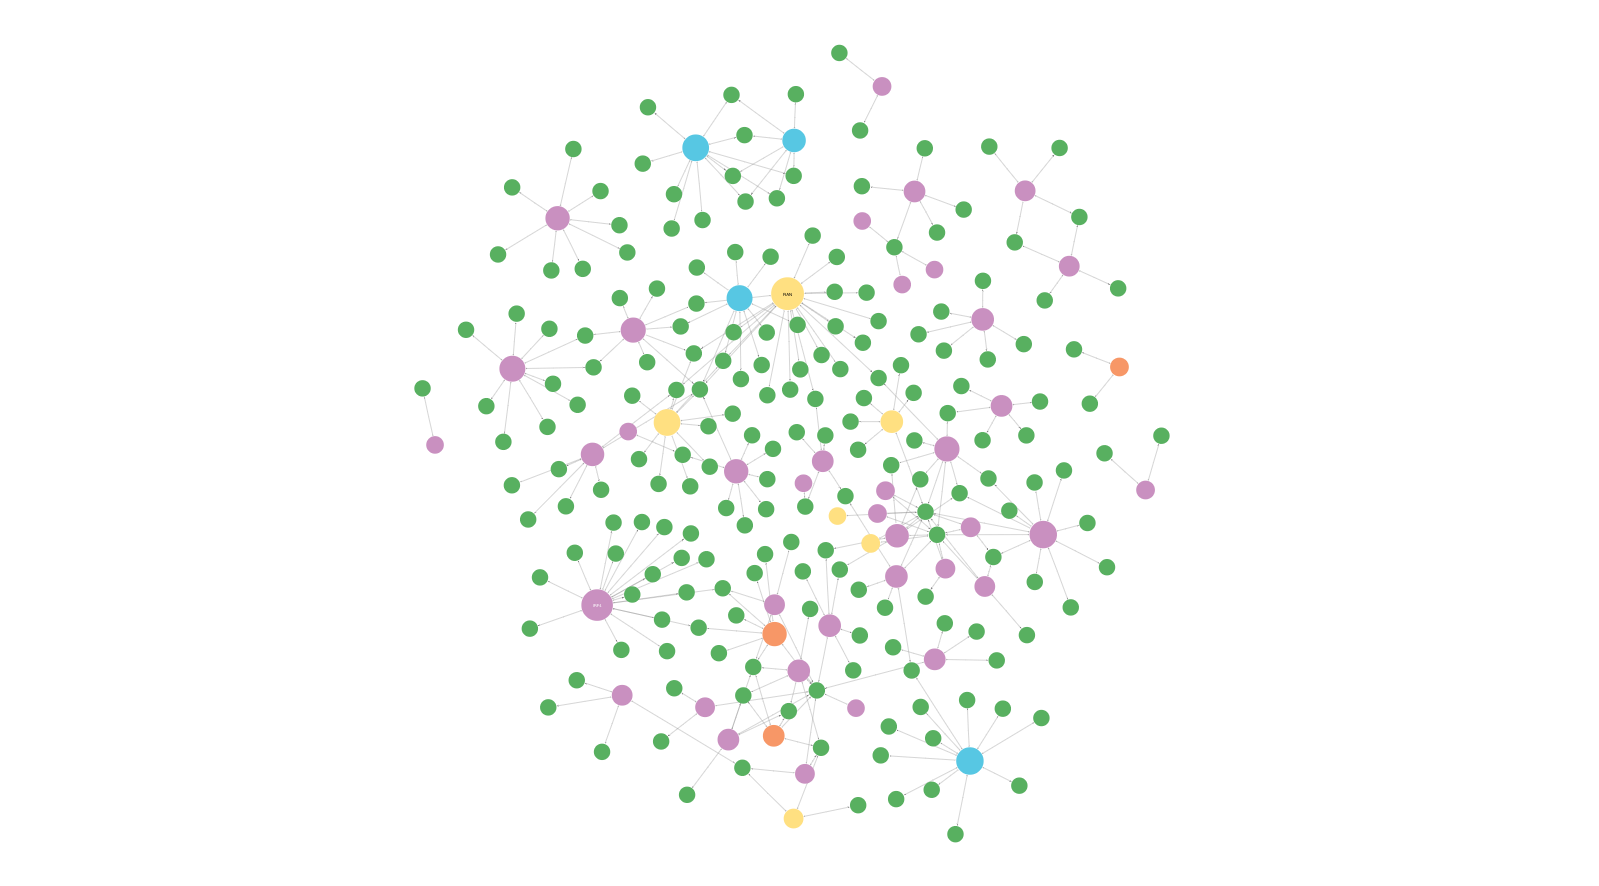

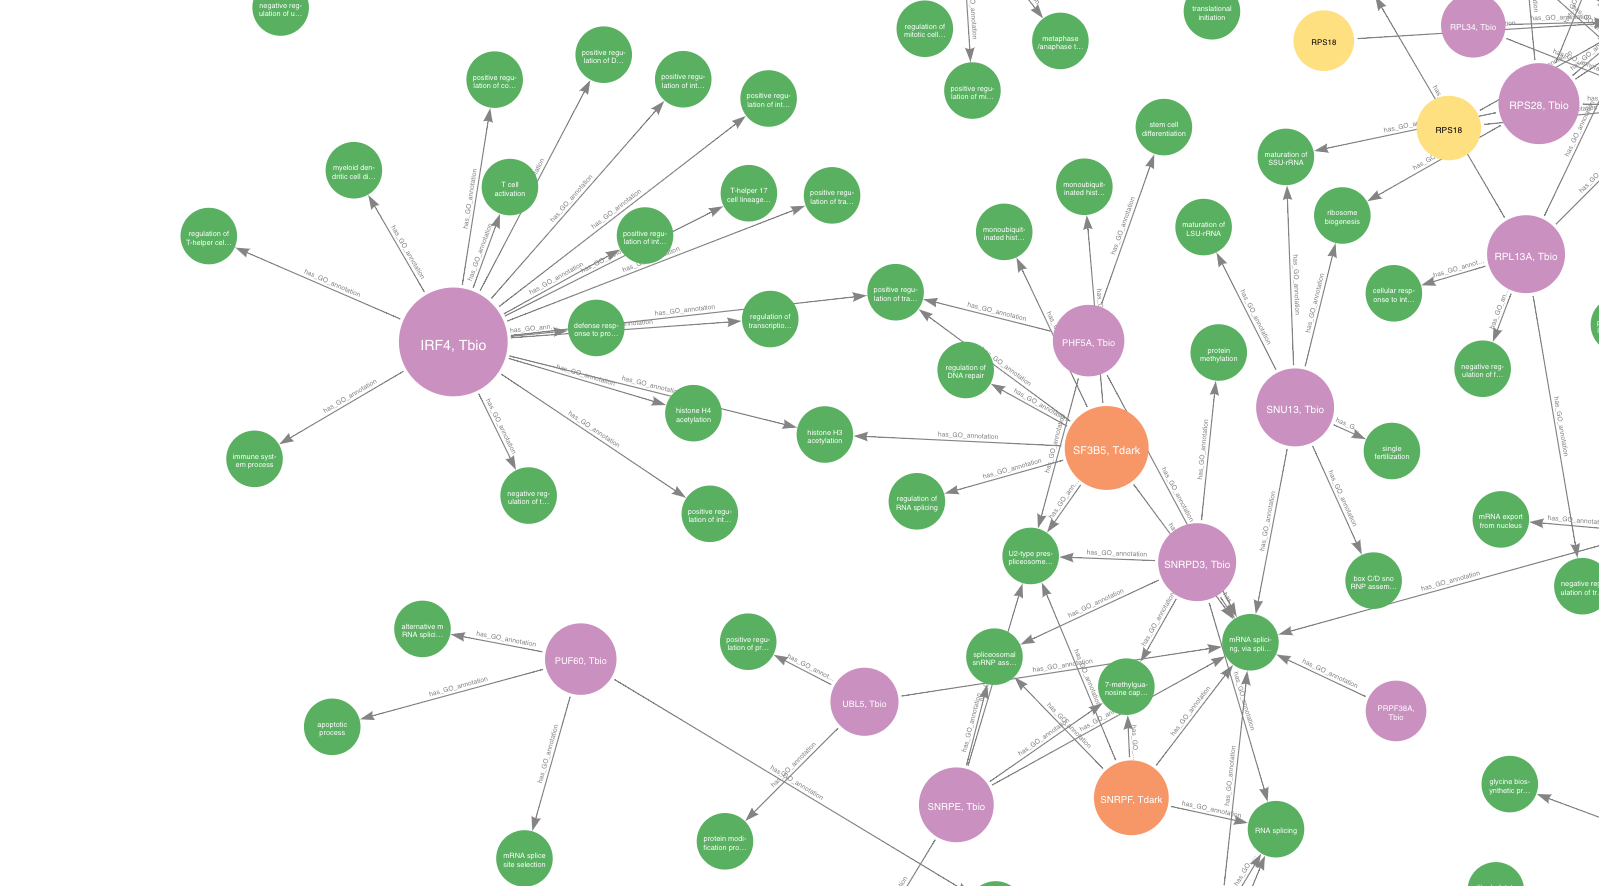

csv exports

In [78]:
bloomdf = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/bloom-export.xlsx')
 
print(bloomdf)

        ~id ~labels                  hgnc_id gene_name       gene_type  \
0       354  Target     2861-01-01T07:00:00Z      DHFR  protein_coding   
1       431  Target  +010362-01-01T07:00:00Z      RPL6  protein_coding   
2       440  Target  +010317-01-01T07:00:00Z    RPL23A  protein_coding   
3       559  Target     7819-01-01T07:00:00Z     SNU13  protein_coding   
4      1124  Target  +021731-01-01T07:00:00Z     PGAM4  protein_coding   
..      ...     ...                      ...       ...             ...   
241  128080      GO                      NaN       NaN             NaN   
242  128471      GO                      NaN       NaN             NaN   
243  128518      GO                      NaN       NaN             NaN   
244  128919      GO                      NaN       NaN             NaN   
245  130811      GO                      NaN       NaN             NaN   

    map_location gene_synonym                            source       RD_id  \
0         5q14.1          NaN  e